# dy/dx = y

In [2]:
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn import *

%load_ext autoreload
%autoreload 2

# quick run for automated notebook validation
dry_run = False

## Generating Data

In [3]:
x = torch.Tensor([[a] for a in torch.linspace(-20, 20, 81)])
y = torch.exp(x.flatten())
print(x)
print(y)

tensor([[-20.0000],
        [-19.5000],
        [-19.0000],
        [-18.5000],
        [-18.0000],
        [-17.5000],
        [-17.0000],
        [-16.5000],
        [-16.0000],
        [-15.5000],
        [-15.0000],
        [-14.5000],
        [-14.0000],
        [-13.5000],
        [-13.0000],
        [-12.5000],
        [-12.0000],
        [-11.5000],
        [-11.0000],
        [-10.5000],
        [-10.0000],
        [ -9.5000],
        [ -9.0000],
        [ -8.5000],
        [ -8.0000],
        [ -7.5000],
        [ -7.0000],
        [ -6.5000],
        [ -6.0000],
        [ -5.5000],
        [ -5.0000],
        [ -4.5000],
        [ -4.0000],
        [ -3.5000],
        [ -3.0000],
        [ -2.5000],
        [ -2.0000],
        [ -1.5000],
        [ -1.0000],
        [ -0.5000],
        [  0.0000],
        [  0.5000],
        [  1.0000],
        [  1.5000],
        [  2.0000],
        [  2.5000],
        [  3.0000],
        [  3.5000],
        [  4.0000],
        [  4.5000],


In [35]:
import torch
import torch.utils.data as data

device = torch.device("cpu")

x_train = torch.Tensor(x).to(device)
y_train = torch.Tensor(y.to(device))
train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(x), shuffle=True)

## Learner

In [42]:
import torch.nn as nn
import pytorch_lightning as pl

class Exponential_Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    # one entire forward pass of the NN
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch      
        print(x)
        print(y)
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.MSELoss()(y_hat, y)
        self.log('train loss', loss)
        return {'loss':loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

## Train

In [43]:
f = nn.Sequential(
        nn.Linear(1, 16),
        nn.ELU(),
        nn.Linear(16, 1),
    )

model = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [44]:
t_span = torch.linspace(0,1,100)
learn = Exponential_Learner(t_span, model)
if dry_run: trainer = pl.Trainer(min_epochs=1, max_epochs=1)
else: trainer = pl.Trainer(min_epochs=200, max_epochs=300)
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 49    
------------------------------------
49        Trainable params
0         Non-trainable params
49        Total params
0.000     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

tensor([[ 18.5000],
        [ 16.5000],
        [-16.5000],
        [-17.0000],
        [ -3.0000],
        [  4.5000],
        [ -9.0000],
        [-20.0000],
        [  1.0000],
        [  5.0000],
        [ -8.5000],
        [  2.0000],
        [  5.5000],
        [ 20.0000],
        [-14.5000],
        [ 19.0000],
        [ 17.0000],
        [  7.5000],
        [ -7.0000],
        [ -1.5000],
        [ -6.5000],
        [-19.0000],
        [ 10.5000],
        [  8.0000],
        [ -4.5000],
        [ 12.5000],
        [  9.5000],
        [  7.0000],
        [-15.0000],
        [  0.5000],
        [ 13.5000],
        [ -5.5000],
        [ -2.5000],
        [ 15.5000],
        [ 14.0000],
        [ 12.0000],
        [ -7.5000],
        [ 17.5000],
        [-13.5000],
        [-12.0000],
        [-10.5000],
        [-12.5000],
        [  1.5000],
        [ 19.5000],
        [  8.5000],
        [-13.0000],
        [ -1.0000],
        [ -2.0000],
        [-18.0000],
        [ 13.0000],


## Plot Results

In [29]:
t_eval, trajectory = model(x_train, t_span)
trajectory = trajectory.detach().cpu()

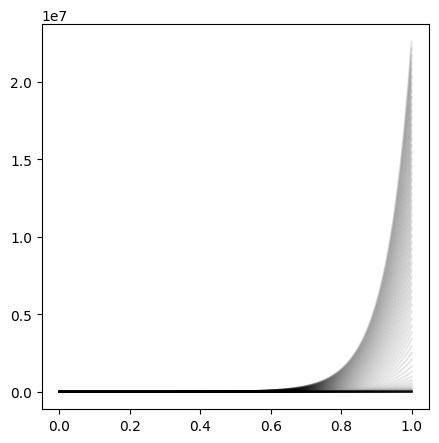

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))
ax0 = fig.add_subplot(111)
for i in range(81):
    ax0.plot(t_span, trajectory[:,i], color='black', alpha=.1);

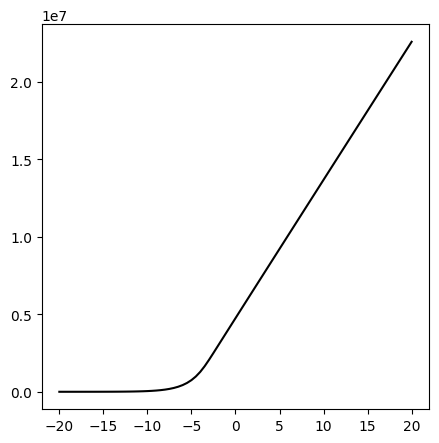

In [31]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(trajectory[0, :], trajectory[-1, :], color='black');

In [32]:
print(len(trajectory[0]))
for i in range(len(trajectory[0])):
    print("x: " + str(trajectory[0][i].item()) + " y_guess: " + str(trajectory[-1][i].item()) + " y: " + str(y[i]))

81
x: -20.0 y_guess: 116.5862045288086 y: tensor(2.0612e-09)
x: -19.5 y_guess: 160.3582000732422 y: tensor(3.3983e-09)
x: -19.0 y_guess: 219.51641845703125 y: tensor(5.6028e-09)
x: -18.5 y_guess: 299.3577575683594 y: tensor(9.2374e-09)
x: -18.0 y_guess: 406.9956359863281 y: tensor(1.5230e-08)
x: -17.5 y_guess: 551.9301147460938 y: tensor(2.5110e-08)
x: -17.0 y_guess: 746.8685302734375 y: tensor(4.1399e-08)
x: -16.5 y_guess: 1008.7855834960938 y: tensor(6.8256e-08)
x: -16.0 y_guess: 1360.296142578125 y: tensor(1.1254e-07)
x: -15.5 y_guess: 1831.54833984375 y: tensor(1.8554e-07)
x: -15.0 y_guess: 2462.747802734375 y: tensor(3.0590e-07)
x: -14.5 y_guess: 3307.378173828125 y: tensor(5.0435e-07)
x: -14.0 y_guess: 4436.51220703125 y: tensor(8.3153e-07)
x: -13.5 y_guess: 5944.68896484375 y: tensor(1.3710e-06)
x: -13.0 y_guess: 7957.470703125 y: tensor(2.2603e-06)
x: -12.5 y_guess: 10641.3427734375 y: tensor(3.7267e-06)
x: -12.0 y_guess: 14217.109375 y: tensor(6.1442e-06)
x: -11.5 y_guess: 189